In [2]:
%pip install numpy
%pip install scipy
%pip install matplotlib
%pip install pyserial
%pip install sympy
%pip install sounddevice

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# For "fast" real FFTs, length must be as follows:
# N=(2^a)*(3^b)*(5^c), a >= 1, b >=0, c >= 0

for a in range(1, 15):
    for b in range(0, 10):
        for c in range(0, 10):
            num = 2**a*3**b*5**c
            if num > 7500 and num < 8500:
                print(f"a{a}b{b}c{c}: {2**a*3**b*5**c}")


a2b4c2: 8100
a5b5c0: 7776
a6b0c3: 8000
a9b1c1: 7680
a13b0c0: 8192


In [4]:
from sympy import factorint

Fs = 48000
Ts = 1 / Fs
# White noise length
noise_dur_s = 0.2
#Nw = int(noise_dur_s * Fs )
Nw = 10000
# Nw needs to be > 3000 (empirical tests)


# Rec length needs to be Nw + around 20m? worth of sample time
# (20m / 343 m/s) * 48000 = around 2800 samples
record_len = Nw + 2800

valid_correlation_len = record_len - Nw + 1
# length of noise will be padded with zeros to get the same size (to make the multiplication in FFT domain possible)

# For FFT using the pffft library, length must round as follows:
# N=(2^a)*(3^b)*(5^c), a >= 5, b >=0, c >= 0 (32, 48, 64, 96, 128, 144, 160, etc are all acceptable lengths)
factors = factorint(record_len)
print(factors)
assert(2 in factors)
assert(factors[2] >=5)
factors.pop(2, None)
factors.pop(3, None)
factors.pop(5, None)
assert(len(factors) == 0)


{2: 9, 5: 2}


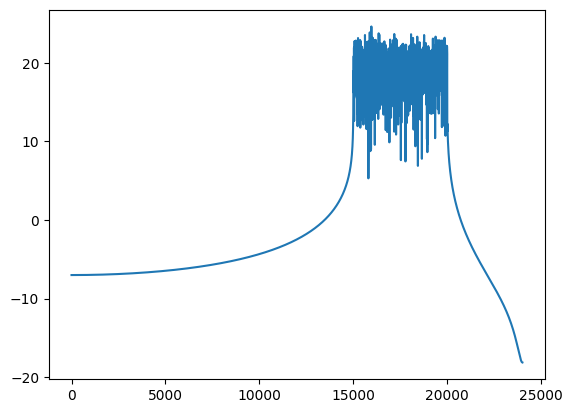

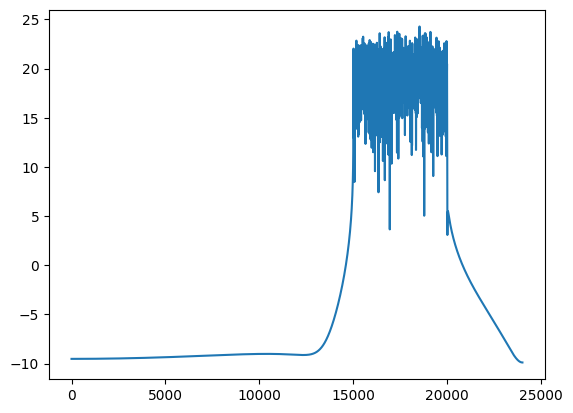

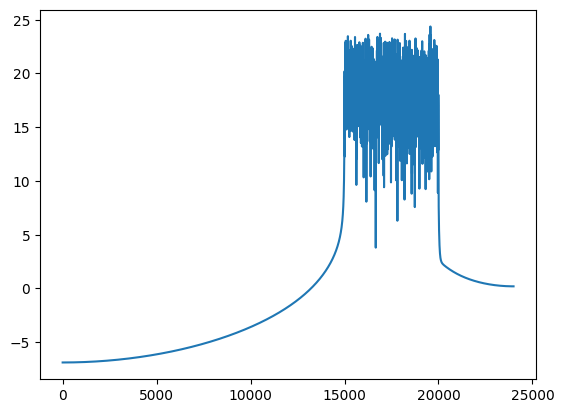

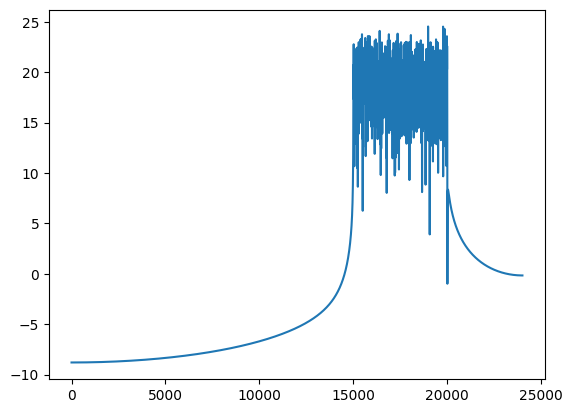

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

# FIR filter
filter_order = 10000000
cutoffs = [15000, 20000]
#cutoffs = [1000, 10000]
#fir_coeff = sp.signal.firwin(filter_order, cutoffs[0], pass_zero='highpass', window='hann', fs=Fs)
#sos_filt = sp.signal.cheby2(filter_order, 100, cutoffs[0], btype='highpass', fs=Fs, output='sos')
fir_coeff = sp.signal.firwin(filter_order, cutoffs, pass_zero='bandpass', window='hann', fs=Fs)
#sp.signal.freqz(fir_coeff, plot=lambda w, h: plt.plot(w*Fs/np.pi/2, 10 * np.log10(np.abs(h))))
#plt.show()

## Generate noise
def make_noise(seed):
    rng = np.random.default_rng(seed)
    white_noise = rng.normal(size=Nw)
    #white_noise = rng.uniform(-1, 1, size=Nw)
    #white_noise = rng.integers(-1, 2, size=Nw)
    #white_noise = rng.integers(2, size=Nw)*2 - 1
    #white_noise = np.cbrt(rng.uniform(-1, 1, size=Nw))
    # plot filter
    

    # Applying the FIR filter to the white noise
    filtered_noise = sp.signal.convolve(white_noise, fir_coeff, mode='same')
    #filtered_noise = sp.signal.sosfilt(sos_filt, white_noise)

    # plot noise
    noise_fft = sp.fft.rfft(filtered_noise)
    n=len(noise_fft)
    f = np.arange(n)*Fs/n/2
    plt.figure()
    plt.plot(f, 10 * np.log10(np.abs(noise_fft)))
    plt.show()

    return filtered_noise / max(filtered_noise)

filtered_noise1 = make_noise(564)
filtered_noise2 = make_noise(661)
filtered_noise3 = make_noise(711)
filtered_noise4 = make_noise(932)

In [6]:
np.save("filtered_noise1.npy", filtered_noise1)
np.save("filtered_noise2.npy", filtered_noise2)
np.save("filtered_noise3.npy", filtered_noise3)
np.save("filtered_noise4.npy", filtered_noise4)

In [7]:
for (i, noise) in enumerate([filtered_noise1, filtered_noise2, filtered_noise3, filtered_noise4]):
    with open(f"../pico_play_noise/src/sound_samples/sound_samples{i}.h", "w") as f:
        noise = np.copy(noise)
        noise *= 2**15-1
        noise = np.asarray(noise, dtype='uint16')
        hexed = [f"0x{sample:04X}" for sample in noise]
        f.write("#include <stddef.h> // for size_t\n")
        f.write("#include <stdint.h> // for uint16_t\n")
        f.write("\n")
        f.write(f"#define SOUND_SAMPLES_LEN {len(hexed)}\n")
        f.write("\n")
        f.write("//These are actually signed ints \n")
        f.write("const uint16_t sound_samples[SOUND_SAMPLES_LEN] = {\n")
        for window in range(0, len(hexed), 10):
            s = "    " + ", ".join(hexed[window:window+10]) + ",\n"
            f.write(s)
        f.write("};\n")


In [8]:
for (i, noise) in enumerate([filtered_noise1, filtered_noise2, filtered_noise3, filtered_noise4]):
    with open(f"pico_fft_test/src/sound_correlation/sound_correlation{i}.h", "w") as f:
        padded = np.pad(noise, (0, record_len-Nw), 'constant', constant_values=0)
        #padded *= 2**15-1
        #padded = np.asarray(padded, dtype='uint32')
        fft = np.fft.rfft(padded)
        #print(len(fft))
        conj = np.conj(fft)
        conj /= np.max(np.abs(conj))
        conj *= 2**15-1
        # length of RFFT is N/2+1 complex numbers
        # We interleave the real and imag
        # Thus we have N+2 nums
        interleaved = np.zeros(len(padded)+2, dtype='uint32') 
        interleaved[0::2] = np.asarray(conj.real, dtype='uint32')
        interleaved[1::2] = np.asarray(conj.imag, dtype='uint32')
        interleaved = [f"0x{f:08X}" for f in interleaved]
        
        f.write("#include <stddef.h> // for size_t\n")
        f.write("\n")
        f.write(f"#define NUMBER_OF_SAMPLES_TO_RECORD {record_len}\n")
        f.write(f"#define NOISE_ACTUAL_LENGTH {Nw}\n")
        f.write(f"#define VALID_CORRELATION_LENGTH {valid_correlation_len}\n")
        f.write("\n")
        f.write(f"#define FFT_SIZE {record_len}\n")
        f.write(f"#define CONV_BUFFER_SIZE {record_len+2}\n")
        f.write("\n")
        f.write("uint32_t recorded_sound[CONV_BUFFER_SIZE] = {0};\n")
        f.write("const uint32_t sound_samples_fft_conj[CONV_BUFFER_SIZE] = {\n")
        for window in range(0, len(interleaved), 10):
            s = "    " + ", ".join(interleaved[window:window+10]) + ",\n"
            f.write(s)
        f.write("};\n") 

""" for (i, noise) in enumerate([filtered_noise, filtered_noise2, filtered_noise3, filtered_noise4]):
    with open(f"pico_fft_test/src/sound_correlation/sound_correlation{i}.h", "w") as f:
        padded = np.pad(noise, (0, record_len-Nw), 'constant', constant_values=0)
        padded *= 2**15-1
        padded = np.asarray(padded, dtype='uint32') << 6
        padded = [f"0x{sample:08X}" for sample in padded]
                
        f.write("#include <stddef.h> // for size_t\n")
        f.write("\n")
        f.write(f"#define NUMBER_OF_SAMPLES_TO_RECORD {record_len}\n")
        f.write(f"#define NOISE_ACTUAL_LENGTH {Nw}\n")
        f.write(f"#define VALID_CORRELATION_LENGTH {valid_correlation_len}\n")
        f.write("\n")
        f.write(f"#define FFT_SIZE {record_len}\n")
        f.write(f"#define CONV_BUFFER_SIZE {record_len+2}\n")
        f.write("\n")
        f.write("uint32_t recorded_sound[CONV_BUFFER_SIZE] = {0};\n")
        f.write("uint32_t sound_samples_fft[CONV_BUFFER_SIZE] = {\n")
        for window in range(0, len(padded), 10):
            s = "    " + ", ".join(padded[window:window+10]) + ",\n"
            f.write(s)
        f.write("};\n")  """


' for (i, noise) in enumerate([filtered_noise, filtered_noise2, filtered_noise3, filtered_noise4]):\n    with open(f"pico_fft_test/src/sound_correlation/sound_correlation{i}.h", "w") as f:\n        padded = np.pad(noise, (0, record_len-Nw), \'constant\', constant_values=0)\n        padded *= 2**15-1\n        padded = np.asarray(padded, dtype=\'uint32\') << 6\n        padded = [f"0x{sample:08X}" for sample in padded]\n                \n        f.write("#include <stddef.h> // for size_t\n")\n        f.write("\n")\n        f.write(f"#define NUMBER_OF_SAMPLES_TO_RECORD {record_len}\n")\n        f.write(f"#define NOISE_ACTUAL_LENGTH {Nw}\n")\n        f.write(f"#define VALID_CORRELATION_LENGTH {valid_correlation_len}\n")\n        f.write("\n")\n        f.write(f"#define FFT_SIZE {record_len}\n")\n        f.write(f"#define CONV_BUFFER_SIZE {record_len+2}\n")\n        f.write("\n")\n        f.write("uint32_t recorded_sound[CONV_BUFFER_SIZE] = {0};\n")\n        f.write("uint32_t sound_samples_f

400 1000 1200 1300


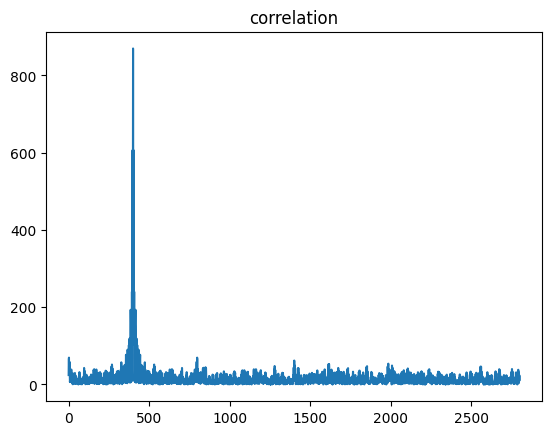

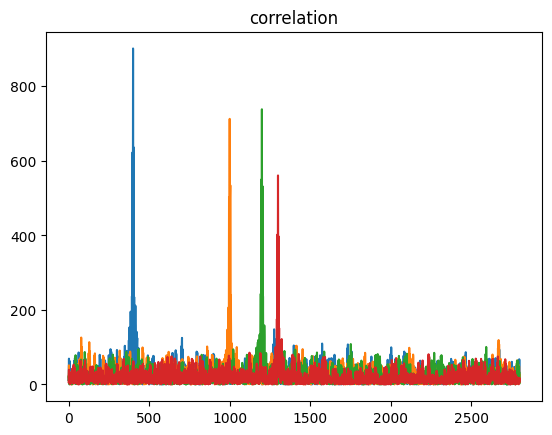

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

def correlate_and_find_delay(rec, noise):
    #rec_padded = np.pad(rec, (len(noise), 0), 'constant', constant_values=0)
    #print(rec)
    rec_fft = np.fft.rfft(rec)
    diff = len(rec)-len(noise)
    noise_padded = np.pad(noise, (0, diff), 'constant', constant_values=0)
    noise_fft_conj = np.conj(np.fft.rfft(noise_padded))
    #print(rec_fft.shape, noise_fft_conj.shape)
    cross_corr_freq = noise_fft_conj * rec_fft 
    cross_corr = np.abs(np.fft.irfft(cross_corr_freq))
    valid_len = diff + 1
    cross_corr = cross_corr[:valid_len]
    #print(cross_corr)
    plt.plot(cross_corr)
    plt.title("correlation")

    k_max_ind = np.argmax(cross_corr)

    return k_max_ind

Fs = 48000

recording_noise_1 = np.zeros(record_len)
recording_noise_2 = np.zeros(record_len)
recording_noise_3 = np.zeros(record_len)
recording_noise_4 = np.zeros(record_len)

insert_loc = 400
recording_noise_1[insert_loc:insert_loc+Nw] += filtered_noise1
insert_loc2 = 1000
recording_noise_2[insert_loc2:insert_loc2+Nw] += filtered_noise2
insert_loc3 = 1200
recording_noise_3[insert_loc3:insert_loc3+Nw] += filtered_noise3
insert_loc4 = 1300
recording_noise_4[insert_loc4:insert_loc4+Nw] += filtered_noise4

recording_noise_together = recording_noise_1 + recording_noise_2 + recording_noise_3 + recording_noise_4
#recording_noise_together = recording_noise_together / max(recording_noise_together)

plt.figure()
ind1 = correlate_and_find_delay(recording_noise_1, filtered_noise1)
plt.figure()
ind1 = correlate_and_find_delay(recording_noise_together, filtered_noise1)
ind2 = correlate_and_find_delay(recording_noise_together, filtered_noise2)
ind3 = correlate_and_find_delay(recording_noise_together, filtered_noise3)
ind4 = correlate_and_find_delay(recording_noise_together, filtered_noise4)
print(ind1, ind2, ind3, ind4)


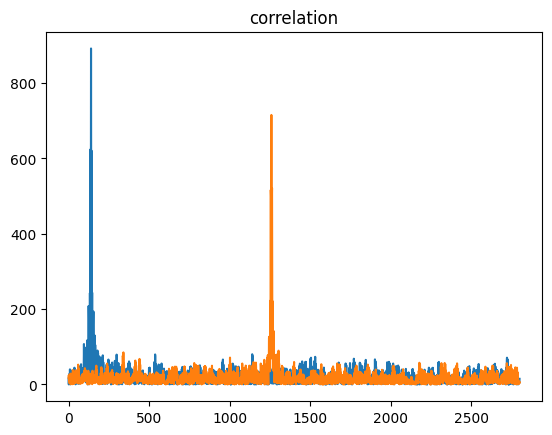

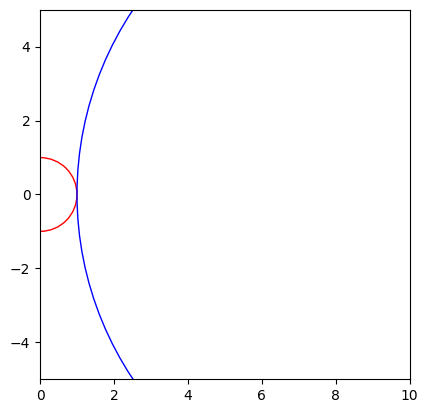

In [10]:
### Time Difference of Arrival with 2 nodes, don't think this is actually accurate lol

p1 = 0  #  0m
p2 = 10  # 10m

delay1 = 1 * Fs // 343  # 5 m in sample time
delay2 = 9 * Fs // 343

recording_noise = np.zeros(record_len)
recording_noise[delay1 : delay1 + Nw] += filtered_noise1
recording_noise[delay2 : delay2 + Nw] += filtered_noise2

plt.figure()
found_delay1 = correlate_and_find_delay(recording_noise, filtered_noise1)
found_delay2 = correlate_and_find_delay(recording_noise, filtered_noise2)

delay_diff = (found_delay1 - found_delay2)/2
dist_from_center = delay_diff / Fs * 343
#dist_from_center = 5

dist_from_p1 = dist_from_center + (p2 - p1)/2
dist_from_p2 = dist_from_center + (p1 - p2)/2

plt.figure()
circle1 = plt.Circle((p1, 0), dist_from_p1, color="r", fill=False)
circle2 = plt.Circle((p2, 0), abs(dist_from_p2), color="b", fill=False)
plt.gca().add_patch(circle1)
plt.gca().add_patch(circle2)
plt.gca().set_xlim(p1, p2)
plt.gca().set_ylim(-5.0, 5.0)
plt.gca().set_aspect("equal")
plt.show()
plt.pause(0.01)

1495


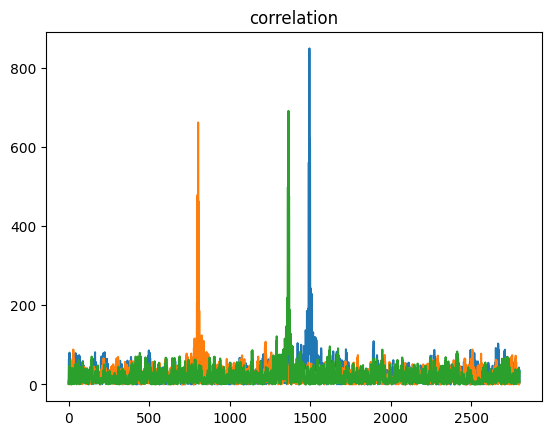

In [87]:
### Time Difference of Arrival with 3 nodes

p1 = np.array([0, 0])
p2 = np.array([10, 0])
p3 = np.array([5, 10])

actual_position = np.array([8, 3])

delay1 = int(abs(np.linalg.norm(p1 - actual_position)) * Fs // 343) + 300
delay2 = int(abs(np.linalg.norm(p2 - actual_position)) * Fs // 343) + 300
delay3 = int(abs(np.linalg.norm(p3 - actual_position)) * Fs // 343) + 300

recording_noise = np.zeros(record_len)
print(delay1)
recording_noise[delay1 : delay1 + Nw] += filtered_noise1
recording_noise[delay2 : delay2 + Nw] += filtered_noise2
recording_noise[delay3 : delay3 + Nw] += filtered_noise3

plt.figure()
found_delay1 = correlate_and_find_delay(recording_noise, filtered_noise1)
found_delay2 = correlate_and_find_delay(recording_noise, filtered_noise2)
found_delay3 = correlate_and_find_delay(recording_noise, filtered_noise3)

## https://en.wikipedia.org/wiki/Pseudo-range_multilateration#Two-dimensional_Cartesian_algorithms

T1 = found_delay1 / Fs
T2 = found_delay2 / Fs
T3 = found_delay3 / Fs

cT1 = T1 * 343
cT2 = T2 * 343
cT3 = T3 * 343

[7.99976057 1.183002  ] [3.00067508 5.12659617]


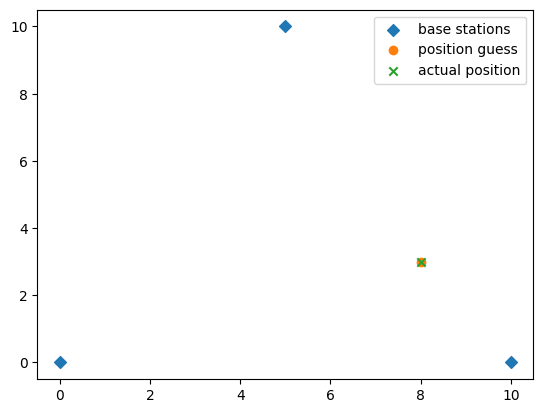

In [88]:
## Fang's algorithm, gotten from the PDF (in the repo or at https://ieeexplore.ieee.org/document/102710)
assert p1[0] == 0 and p1[1] == 0
assert p2[0] > 0 and p2[1] == 0
assert p3[1] > 0

A = p1
B = p2
C = p3

b = B[0]  # also = np.linalg.norm(B)
cx = C[0]
cy = C[1]
c = np.linalg.norm(C)

Rab = cT1 - cT2
Rac = cT1 - cT3

# variable names correspond to those in the paper

g = (Rac * b / Rab - cx) / cy
h = (c**2 - Rac**2 + Rac * Rab * (1 - (b / Rab) ** 2)) / (2 * cy)

d = -(1 - (b / Rab) ** 2 + g**2)
e = b * (1 - (b / Rab) ** 2) - 2 * g * h
f = (Rab**2 / 4) * (1 - (b / Rab) ** 2) ** 2 - h**2

z = 0
x = np.roots([d, e, f - z**2])  # eq 9a
y = g * x + h  # eq 13
print(x, y)

guess1 = np.array([x[0], y[0]])
guess2 = np.array([x[1], y[1]])


def err(g):
    deltaA = np.linalg.norm(g - A)
    deltaB = np.linalg.norm(g - B)
    deltaC = np.linalg.norm(g - C)
    rab = deltaA - deltaB
    rac = deltaA - deltaC
    mse = ((rab - Rab) ** 2 + (rac - Rac) ** 2) / 2
    return mse


best_guess = min([guess1, guess2], key=err)


plt.figure()
plt.scatter(
    [p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]], label="base stations", marker="D"
)
plt.scatter(best_guess[0], best_guess[1], label="position guess")
plt.scatter(actual_position[0], actual_position[1], label="actual position", marker="x")
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

thing = """"""

y = thing.splitlines()
print(y)
y = [abs(int(s)) for s in y]

plt.plot(y)


In [ ]:
import serial
import scipy as sp
import numpy as np 

fs, samples = sp.io.wavfile.read("song3.wav")
samples = samples // 8
print(fs, samples.dtype)
assert(samples.dtype == np.int16)
sample_bytes = samples.tobytes()

ser = serial.Serial("/dev/ttyACM1", 115200)
ser.write(sample_bytes)
ser.flush()
print("done")

In [ ]:
import serial
import scipy as sp
import numpy as np 

ser = serial.Serial("/dev/ttyACM1", 115200)
ser.write(b"r")
b = ser.read(48000 * 2 * 5)

#samples = np.frombuffer(b, dtype=np.uint32)
#samples = (samples)
#samples = np.frombuffer(samples.tobytes(), dtype=np.int32)
samples = np.frombuffer(b, dtype=np.int16)
import sounddevice as sd

sd.play(samples, 48000)
sd.wait()
for i in samples:
    print(hex(i))

In [ ]:
thing = """"""

ke = thing.splitlines()
ke = [a.split(" ") for a in ke]
ke = [int(a[0], 16) + 1j*int(a[1], 16) for a in ke]
print(np.max(np.abs(ke)))

In [ ]:
#Used with pico_record_noise, plays the sound samples as they are received
import serial

ser = serial.Serial("/dev/ttyACM6", 115200)
#ser.set_buffer_size(rx_size = 8192)
while True:
    line = ser.readline().strip()
    if line != b'bytes':
        if len(line) < 100:
            print(line)
        continue
    size = ser.readline().strip()
    size = int(size.decode('utf-8'))
    print(size)
    b = ser.read(size)
    corr = np.frombuffer(b, dtype='<i4')
    plt.plot(np.abs(corr))
    break